In this notebook, I will develop tools to compute the exact advective tendencies using the velocities around the edge.

In [1]:
from xnoah.sam import coarsen
import numpy as np
import dask.array as da

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

# Load the data

In [3]:
import glob, os, re
from toolz import assoc, groupby, keymap, valmap
from toolz.curried import get, map, groupby
from collections import defaultdict
import xarray as xr

directory = "/home/disk/eos7/guest/SAM6.10.6_NG/continuation/OUT_3D"
files = os.listdir(directory)

# define a regex for reading the filenames
pattern = re.compile(r"(?P<run>.*)_(?P<time>\d+)_(?P<field>\w+)\.nc")

# parse files to list of dicts
file_matches = map(pattern.search, files)
file_info = [assoc(m.groupdict(), 'path', m.string) for m in file_matches]

# get list of runs
runs = groupby(get('run'), file_info)
runs = valmap(groupby('time'), runs)

time_steps = keymap(int, runs['NG_5120x2560x34_4km_10s_QOBS_EQX_1280'])
time_steps = valmap(map(lambda x: os.path.join(directory, x['path']), ), time_steps)
time_steps = valmap(list, time_steps)

In [4]:
first_step = sorted(time_steps)[0]
ds = xr.open_mfdataset(time_steps[first_step])
first_step

519480

Load 2D data

In [5]:
files_2d = glob.glob("/home/disk/eos13/guest/SAM6.10.6_NG/OUT_2D/*")
pattern = re.compile(r".*\/(?P<run>.*)_(?P<time>\d+)\.2Dcom.*nc")


# find the corresponding 2d files
for f in files_2d:
    m = pattern.search(f)
    if m:
        if m.group('run') == 'NG_5120x2560x34_4km_10s_QOBS_EQX_1280':
            if int(m.group('time')) == first_step:
                a = m.string
                
                
data_2d = xr.open_dataset(a)
stat = xr.open_dataset("/home/disk/eos13/guest/SAM6.10.6_NG/OUT_STAT/NG_5120x2560x34_4km_10s_QOBS_EQX.nc")

# Divergence-free in slice

In [6]:
z = ds.z.values
z = np.hstack((-z[0], z, z[-1]*2 - z[-2]))
zh = .5*(z[1:] + z[:-1])
dz = np.diff(zh)

rho = stat.RHO[-1].values
rho.shape = (-1,  1)
dz.shape = (-1, 1)

j = 1000

u = ds.U.isel(y=j, time=0).values
u = np.pad(u, [(0,0), (0, 1)], mode='wrap')

v = ds.V.isel(y=slice(j,j+2), time=0).values
w = ds.W.isel(y=j, time=0).values


d = np.diff(u, axis=-1)/4000 + (v[:, 1,:]-v[:,0,:])/4000

div_integral = -(rho * d * dz).cumsum(axis=0)

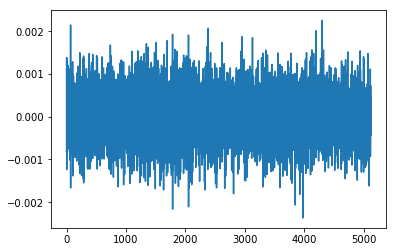

In [7]:
plt.plot(div_integral[-1])

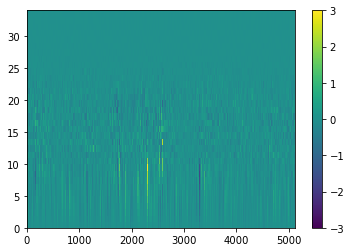

In [8]:
plt.pcolormesh(div_integral, vmin=-3, vmax=3)
plt.colorbar()

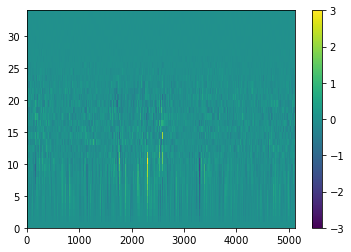

In [9]:
plt.pcolormesh(w*rho,  vmin=-3, vmax=3)
plt.colorbar()

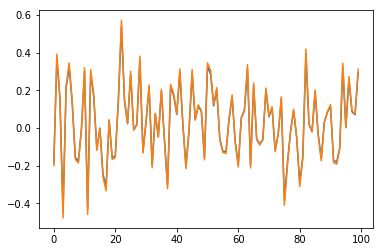

In [10]:
plt.plot((w*rho)[20,:100])
plt.plot(div_integral[19,:100])

This shows that the divergence free condition exactly matches in a slice.

# Break Data into blocks

$$ - \iint \frac{1}{\rho_0}(w  \rho_0)_z dx dy  = \iint  \nabla \cdot (u,v) dx dy = \oint (u,v)\cdot dS $$

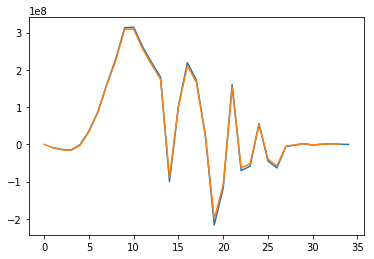

In [11]:
from xnoah.sam import coarsen
import numpy as np
import dask.array as da

dx = dy = 4000


U = ds.U.values
V = ds.V.values
W = ds.W.values

i,j = 10, 10

ileft = 10 * 40 
iright = 11*40

jdown = j*40
jup = (j+1)*40


rho = np.reshape(rho, (-1))
dz = np.reshape(dz, (-1))

ux = (U[:,:,jdown:jup,iright]- U[:,:,jdown:jup, ileft]).sum(-1)*dy
vy = (V[:,:,jup,ileft:iright]- V[:,:,jdown,ileft:iright]).sum(-1)*dx
w = W[:,:,jdown:jup, ileft:iright].sum(-1).sum(-1)*dx*dy

dij = (ux + vy)
wpred = -(dij*rho*dz).cumsum(axis=1)

plt.plot(np.arange(1,35), wpred[0])
plt.plot(rho*w[0])
# plt.plot(d[0,:,i,j])

# Using windowsing

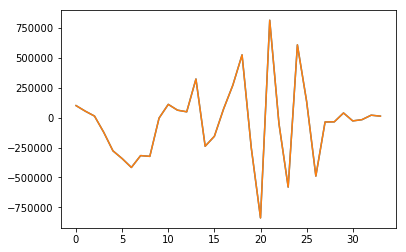

In [12]:
def blocks_view(U):
    blocks = {2:40, 3: 40}
    nt, nz, ny, nx = U.shape
    return U.reshape((nt, nz, ny//blocks[2], blocks[2], nx//blocks[3], blocks[3]))


Uw = blocks_view(U)
Vw = blocks_view(V)
Ww = blocks_view(W)

ux = (Uw[:,:, j, :, i+1, 0] - Uw[:,:, j, :, i, 0]).sum(-1)*dy
vy = (Vw[:,:, j+1, 0, i, :] - Vw[:,:, j, 0, i, :]).sum(-1)*dx

U_int = Uw[:,:,:,:,:,0].sum(axis=-2)*dy
V_int = Vw[:,:,:,0].sum(axis=-1)*dx
ux = (U_int[:,:,j, i+1] - U_int[:,:, j, i])
vy = (V_int[:,:, j+1, i] - V_int[:,:, j, i])

d = ux + vy

plt.plot(d[0])
plt.plot(dij[0])

# Full domain

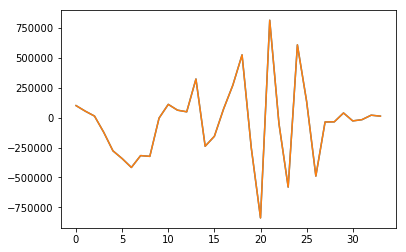

In [13]:
from scipy.ndimage import correlate1d


rho = np.reshape(rho, (-1, 1, 1))
dz = np.reshape(dz, (-1, 1, 1))

def diff(x, axis=-1, mode='wrap'):
    return correlate1d(x, [-1, 1], axis=axis, mode=mode, origin=-1)

ux = diff(U_int, axis=-1)
vy = diff(V_int, axis=-2)

d = ux + vy

plt.plot(d[0,:,i,j])
plt.plot(dij[0])

this matches also.

## integrate to get w

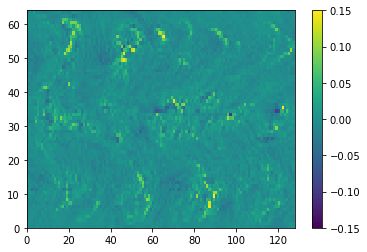

In [14]:
d_int = -(d*rho*dz).cumsum(1)/dx**2/40**2
w = d_int

plt.pcolormesh(d_int[0,11,:], vmin=-.15, vmax=.15)
plt.colorbar()

Here is the true W

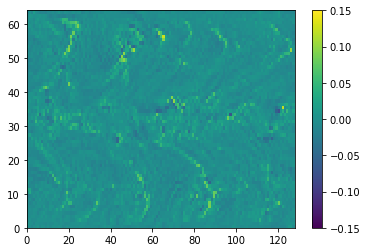

In [15]:
W_avg = Ww.mean(axis=-1).mean(axis=-2)
plt.pcolormesh(rho[10]*W_avg[0,10], vmin=-.15, vmax=.15)
plt.colorbar()

They very closely match, as we can see.